In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sn
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
import copy
import yaml

In [2]:
class Run:
    def __init__(self, checkpoints, compare_checkpoints, root_folder="output/", name="NotGiven", columns=[]):            
        
        dict_list=[]
        for dataset in checkpoints.keys():
            for model in checkpoints[dataset].keys():
                for idx, checkpoint in enumerate(checkpoints[dataset][model]):     
                    # print(dataset,model,checkpoint)
                    # print(os.path.join(root_folder,dataset,model,f"version_{checkpoint}"))
                    learning_rate,max_epochs,weight_decay,optimizer=self.get_hyperparameters(os.path.join(root_folder,dataset,model,f"version_{checkpoint}"))
                    acc,loss = self.get_metrics(os.path.join(root_folder,dataset,model,f"version_{checkpoint}"))
                    dict_list.append({
                        "model":model,
                        "dataset":dataset,
                        "checkpoint":checkpoint if len(columns)==0 else columns[idx],
                        "type":"MinimizedDataset",
                        "accuracy":float(acc),
                        "loss":float(loss),
                        "learning_rate":learning_rate,
                        "max_epochs":max_epochs,
                        "weight_decay": weight_decay,
                        "optimizer": optimizer
                    })
                    
        for dataset in compare_checkpoints.keys():            
            for model in compare_checkpoints[dataset].keys():                  
                for idx,checkpoint in enumerate(compare_checkpoints[dataset][model]):
                    learning_rate,max_epochs,weight_decay,optimizer=self.get_hyperparameters(os.path.join(root_folder,dataset,model,f"version_{checkpoint}"))
                    acc,loss = self.get_metrics(os.path.join(root_folder,dataset,model,f"version_{checkpoint}"))
                    dict_list.append({
                        "model":model,
                        "dataset":dataset,
                        "checkpoint":checkpoint if len(columns)==0 else columns[idx],
                        "type":"FullDataset",
                        "accuracy":float(acc),
                        "loss":float(loss),
                        "learning_rate":learning_rate,
                        "max_epochs":max_epochs,
                        "weight_decay": weight_decay,
                        "optimizer": optimizer
                    })
              
        self.run_df = pd.DataFrame.from_records(dict_list)
        self.name = name        
                    
        
                
    def get_metrics(self,root):    
        df_tmp = pd.read_csv(os.path.join(root,"metrics.csv"))
        acc=float(df_tmp[df_tmp['acc/val'] == df_tmp['acc/val'].max()]['acc/val'].values[0])
        loss = float(df_tmp[df_tmp['acc/val'] == df_tmp['acc/val'].max()]['loss/val'].values[0])
        return acc,loss
    
    def get_hyperparameters(self,root):
        with open(os.path.join(root,"hparams.yaml")) as stream:
            data_loaded = yaml.safe_load(stream)        
        learning_rate=float(data_loaded['hparams']['learning_rate'])
        max_epochs=int(data_loaded['hparams']['max_epochs'])
        weight_decay=float(data_loaded['hparams']['weight_decay'])
        optimizer=str(data_loaded['hparams']['optimizer'])
        return learning_rate,max_epochs,weight_decay,optimizer    
    
    def get_metrics_by_dataset(self,dataset):
        temp_df_metric_acc=self.run_df[(self.run_df['dataset']==dataset) & (self.run_df['type']=="MinimizedDataset")].set_index(['model','checkpoint'])['accuracy'].subtract(self.run_df[(self.run_df['dataset']==dataset) & (self.run_df['type']=="FullDataset")].set_index(['model','checkpoint'])['accuracy']).reset_index().pivot_table('accuracy','checkpoint','model')
        temp_df_metric_loss=self.run_df[(self.run_df['dataset']==dataset) & (self.run_df['type']=="MinimizedDataset")].set_index(['model','checkpoint'])['loss'].subtract(self.run_df[(self.run_df['dataset']==dataset) & (self.run_df['type']=="FullDataset")].set_index(['model','checkpoint'])['loss']).reset_index().pivot_table('loss','checkpoint','model')
        temp_df_acc=self.run_df[(self.run_df['dataset']==dataset) & (self.run_df['type']=="MinimizedDataset")].set_index(['model','checkpoint'])['accuracy'].reset_index().pivot_table('accuracy','checkpoint','model')
        temp_df_loss=self.run_df[(self.run_df['dataset']==dataset) & (self.run_df['type']=="MinimizedDataset")].set_index(['model','checkpoint'])['loss'].reset_index().pivot_table('loss','checkpoint','model')
        
        return temp_df_acc,temp_df_loss,temp_df_metric_acc,temp_df_metric_loss
        

In [3]:
def range_version(start,end):
    return list(range(start,end+1))

In [4]:
def generate_simple_runs(checkpoints,compare_checkpoint,root_folder,models, dataset,checkpoint_names):
    runs=[]
    
            
    for name, checkpoint in checkpoints.items():
        run_config=dict()
        run_config_compare=dict()
        run_config[dataset]=dict()
        run_config_compare[dataset]=dict()
        for model in models:
            run_config[dataset][model]=checkpoint
            run_config_compare[dataset][model]=[compare_checkpoint]*len(checkpoint)
        # print(run_config)
        runs.append(Run(run_config,run_config_compare,root_folder,columns=checkpoint_names,name=name))
                    
    return runs
            
        

In [103]:
def create_plot_df(df,dataset="cifar10"):
    df_full=df[(df["dataset"]==dataset)&(df["type"]=="FullDataset")].drop(["dataset","type",'learning_rate','max_epochs','weight_decay','optimizer'],axis=1).set_index(['checkpoint'])
    df_minimized=df[(df["dataset"]==dataset)&(df["type"]=="MinimizedDataset")].drop(["dataset","type",'learning_rate','max_epochs','weight_decay','optimizer'],axis=1).set_index(['checkpoint'])
    
    df_full['accuracy_min']=df_minimized['accuracy']
    df_full['loss_min']=df_minimized['loss']
    df_full['accuracy_diff']=df_minimized['accuracy'].subtract(df_full['accuracy'])
    df_full['loss_diff']=df_minimized['loss'].subtract(df_full['loss'])  
    
    return df_full

def bar_plot(runs):    
    runs=runs.copy()
    runs.reverse()
    
    models=runs[0].run_df["model"].unique()
    nrows=len(models)
    ncols=1    

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, len(models)*5))

    # models=np.reshape(models,(nrows,ncols))
    
    barWidth=0.05 
    center = 0.5

    sn.set_theme()
    
  
    if(nrows % 2 != 0):
        positions=[-len(runs)/2+p+1 for p in np.arange(nrows)]
    if(nrows % 2 == 0):
        nr=len(runs)+1
        positions=[-nr/2+p+1 for p in np.arange(nr)]
        middle=int(np.floor(nr/2))        
        positions=list((np.array(positions[:middle])+0.5)) + list((np.array(positions[middle + 1:])-0.5))     
        
    
    for row in range(nrows):
        for run,position in zip(runs,positions):
            df_temp = create_plot_df(run.run_df,run.run_df['dataset'].unique()[0])            
            # df2_full[df2_full["model"]==models[row,col]].rename(columns={'accuracy':'Pretraining','accuracy_diff':'FineTuning'})[['Pretraining','FineTuning']].plot(position=0,width=0.25,title=models[row,col],ax=axes[row][col],rot=0,kind="bar",stacked=True)
            df_temp[df_temp["model"]==models[row]].rename(columns={'accuracy':'Ohne Pretraining','accuracy_min':"FineTuning",'accuracy_diff':'Differenz'})[['Ohne Pretraining','FineTuning','Differenz']] \
                .plot(title=models[row],ax=axes[row],rot=0,kind="bar",stacked=True,width=barWidth,position=position)            
            
            # df_minimized[df_minimized["model"]==models[row,col]][['accuracy','accuracy_diff']].plot(position=1,width=0.1,title=models[row,col],ax=axes[row][col],rot=0,kind="bar",stacked=True)
            # df_minimized[df_minimized["model"]==models[row,col]][['accuracy','accuracy_diff']].plot(position=2,width=0.1,title=models[row,col],ax=axes[row][col],rot=0,kind="bar",stacked=True)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    for idx,ax in enumerate(axes):
        axes[idx].legend(by_label.values(), by_label.keys(),loc='lower right')  
        
        # print(axes[idx].containers)
        
        for c in axes[idx].containers:
            # Optional: if the segment is small or 0, customize the labels
            labels = [f'{round((v.get_height()/100)*100)}' for v in c]

            # remove the labels parameter if it's not needed for customized labels
            axes[idx].bar_label(c,labels=labels, label_type='center',rotation=0,fontsize=8,padding=0)
            # axes[idx].bar_label(c,labels=list(map(lambda x: x.name , runs)), label_type='edge',rotation=90)
            
    
    # axes.suptitle('lowres_resnet9', fontsize=20)
    # axes.set_xlabel("Pretrained Models")
    # fig.ylabel("Accuracy in %")
    # params = {'legend.fontsize': 16,
    #       'figure.figsize': (15, 5),
    #      'axes.labelsize': 18,
    #      'axes.titlesize':20,   
    #      'axes.labelpad': 20,
    #      # 'xtick.labelsize':18,
    #      # 'ytick.labelsize':18
    #          }
    # pylab.rcParams.update(pylab.rcParamsDefault)
    # pylab.rcParams.update(params)
    # print(pylab.rcParams.keys())
    axes[0].set_ylabel("Accuracy in %")
    axes[1].set_ylabel("Accuracy in %")
    axes[2].set_ylabel("Accuracy in %")
    axes[3].set_ylabel("Accuracy in %")
    
    runs.reverse()
    axes[0].set_xlabel(f"Used pretrained model/checkpoint - Bars({list(map(lambda x: x.name , runs))})")       
    axes[1].set_xlabel(f"Used pretrained model/checkpoint - Bars({list(map(lambda x: x.name , runs))})")  
    axes[2].set_xlabel(f"Used pretrained model/checkpoint - Bars({list(map(lambda x: x.name , runs))})")  
    axes[3].set_xlabel(f"Used pretrained model/checkpoint - Bars({list(map(lambda x: x.name , runs))})")  
    
    fig.tight_layout()
    # fig.suptitle('Lowr>es Resnet 9', fontsize=18)
    return fig

In [32]:


cifar10_run_checkpoints={
    "cifar10": {
        "lowres_resnet9":[0,1,2,3,4],
        "lowres_resnet50":[0,1,2,3,4],
        "lowres_densenet121":[0,1,2,3,4],
        "lowres_vgg16_bn":[0,1,2,3,4],
               }    
}
cifar10_run_compare_checkpoints={
    "cifar10": {
        "lowres_resnet9":[5,5,5,5,5],
        "lowres_resnet50":[5,5,5,5,5],
        "lowres_densenet121":[5,5,5,5,5],
        "lowres_vgg16_bn":[5,5,5,5,5],
               } 
}

cifar100_run_checkpoints={
    "cifar100": {
        "lowres_resnet9":[0,1,2,3,4],
        "lowres_resnet50":[0,1,2,3,4],
        "lowres_densenet121":[0,1,2,3,4],
        "lowres_vgg16_bn":[0,1,2,3,4],
               }    
}
cifar100_run_compare_checkpoints={
    "cifar100": {
        "lowres_resnet9":[5,5,5,5,5],
        "lowres_resnet50":[5,5,5,5,5],
        "lowres_densenet121":[5,5,5,5,5],
        "lowres_vgg16_bn":[5,5,5,5,5],
               } 
}

grocerystore_run_checkpoints={
    "grocerystore": {
        "lowres_resnet9":[0,1,2,3,4],
        "lowres_resnet50":[0,1,2,3,4],
        "lowres_densenet121":[0,1,2,3,4],
        "lowres_vgg16_bn":[0,1,2,3,4],
               }    
}
grocerystore_run_compare_checkpoints={
    "grocerystore": {
        "lowres_resnet9":[5,5,5,5,5],
        "lowres_resnet50":[5,5,5,5,5],
        "lowres_densenet121":[5,5,5,5,5],
        "lowres_vgg16_bn":[5,5,5,5,5],
               } 
}

svhn_run_checkpoints={
    "svhn": {
        "lowres_resnet9":[0,1,2,3,4],
        "lowres_resnet50":[0,1,2,3,4],
        "lowres_densenet121":[0,1,2,3,4],
        "lowres_vgg16_bn":[0,1,2,3,4],
               }    
}
svhn_run_compare_checkpoints={
    "svhn": {
        "lowres_resnet9":[5,5,5,5,5],
        "lowres_resnet50":[5,5,5,5,5],
        "lowres_densenet121":[5,5,5,5,5],
        "lowres_vgg16_bn":[5,5,5,5,5],
               } 
}

tinyimagenet_run_checkpoints={
    "tinyimagenet": {
        "lowres_resnet9":[0,1,2,3,4],
        "lowres_resnet50":[0,1,2,3,4],
        "lowres_densenet121":[0,1,2,3,4],
        "lowres_vgg16_bn":[0,1,2,3,4],
               }    
}
tinyimagenet_run_compare_checkpoints={
    "tinyimagenet": {
        "lowres_resnet9":[5,5,5,5,5],
        "lowres_resnet50":[5,5,5,5,5],
        "lowres_densenet121":[5,5,5,5,5],
        "lowres_vgg16_bn":[5,5,5,5,5],
               } 
}



checkpoint_names=[
    "cifar10_model",
    "cifar100_model",
    "grocerystore_model",
    "svhn_model",
    "tinyimagenet_model"
]

In [98]:
runs=[
    Run(cifar10_run_checkpoints,cifar10_run_compare_checkpoints,"output_sweep_complete/",columns=checkpoint_names,name="Run Complete - Cifar10"),
    Run(cifar100_run_checkpoints,cifar100_run_compare_checkpoints,"output_sweep_complete/",columns=checkpoint_names,name="Run Complete - Cifar100"),
    Run(grocerystore_run_checkpoints,grocerystore_run_compare_checkpoints,"output_sweep_complete/",columns=checkpoint_names,name="Run Complete - Grocerystore"),
    Run(svhn_run_checkpoints,svhn_run_compare_checkpoints,"output_sweep_complete/",columns=checkpoint_names,name="Run Complete - SVHN"),
    Run(tinyimagenet_run_checkpoints,tinyimagenet_run_compare_checkpoints,"output_sweep_complete/",columns=checkpoint_names,name="Run Complete - Tinyimagenet")
]

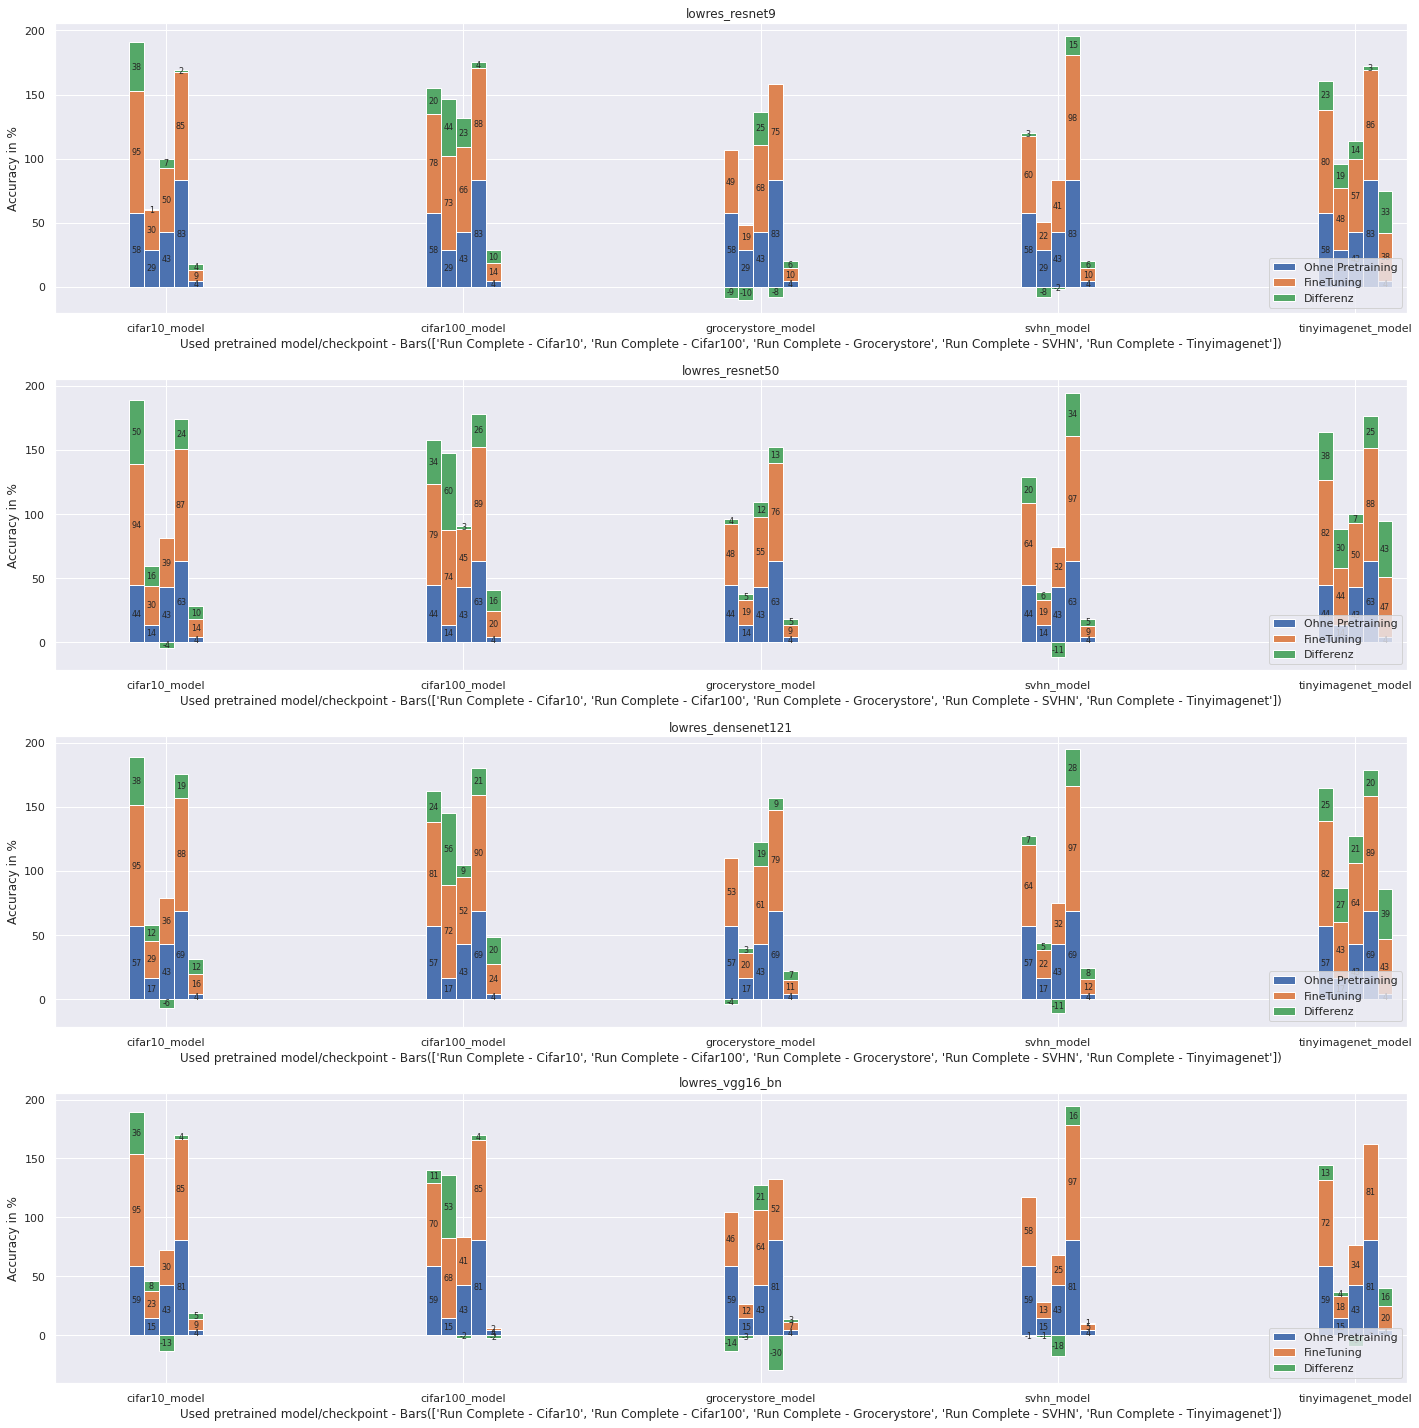

In [105]:
fig=bar_plot(runs)

In [106]:
fig.savefig("completesweep.png",dpi=600)